# Data project by Laurits, Victor and Jens

## Introduction
Welcome to our project.

The following is centered around US Stock Data, which is downloaded from [AlphaVantage](http://www.alphavantage.com), an online service that provides free access to financial data in an easily-accesible format through URL-calls.

We have focused on making our code interactive, responsive and dynamic, meaning that the code will run independent on the stock data we load. To underline this, we include more than 20 years of data on *Apple* (AAPL), *Microsoft* (MSFT), *Boeing* (BA) and *AIG* (AIG). Furthermore, we invite you to include a stock of your own liking below – if you want. The code will run with or without the additional stock.

The project makes the most sense, if you read each paragraph and run each piece of code chronically. Let's get started!

## Fetching data
We start by importing the neccesary modules and packages.

In [3]:
# Import neccesary modules and packages #
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interactive, interact, interact_manual
print("Import succesful.\n")

Import succesful.



Then we set the ticker-codes for the stock that we use in the analysis. This is also where you come in to play – first run the code, then in the interactive field, feel free to add a ticker code! The code should work with any stock – just make sure that you input a valid ticker code for an American stock (e.g. *XOM* for Exxon Mobile).

In [5]:
tickers = ["AAPL","MSFT","BA","AIG"]
def set_tickers(custom_ticker):
    if len(custom_ticker) > 1:
        global tickers
        tickers = ["AAPL","MSFT","BA","AIG",custom_ticker.upper()]
        print("Awesome - you added " + tickers[4] + "! No need to re-run any code. This stock will now be included in the analysis.\nPlease note that the code will fail, if this is not a valid US stock ticker-code.\n\n--------------------------")

set_ticker = interactive(set_tickers, custom_ticker="", description="Your ticker:")
set_ticker.children[0].description = 'Add a ticker:'
set_ticker

interactive(children=(Text(value='', description='Add a ticker:'), Output()), _dom_classes=('widget-interact',…

With the ticker-codes in place, we are ready to build the download-link and load data into individual Pandas DataFrames, which we append to the main *stocks_df* DataFrame through a loop. 

Run the code below to start the download of data. Just be aware that the files are relatively large (they contain more than 20 years of data, after all), why the download likely will take around a minute.

In [6]:
# EXAMPLE LINK: https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=AAPL&outputsize=full&apikey=XU0S88ZM101LB0FQ&datatype=csv

#Notify everything's OK!
print("Downloading data...\n")

# SET ATTRIBUTES FOR DATA FETCH #
apikey = "XU0S88ZM101LB0FQ" 
outputsize = "full" # Compact or full, if daily data. Compact is 100 days, full is 20+ years.
freq = "DAILY" # DAILY, WEEKLY OR MONTHLY

# Empty Panda DataFrame to append individual stock data to 
stocks_df = pd.DataFrame() 

# Loop through tickercodes and fetch data individually, then append to stocks_df
for ticker in tickers:
    fetch_link = "https://www.alphavantage.co/query?function=TIME_SERIES_" + freq + "_ADJUSTED&symbol=" + ticker + "&outputsize=" + outputsize + "&apikey=" + apikey + "&datatype=csv"
    df = pd.read_csv(fetch_link)
    df["ticker"] = ticker
    print(ticker + " has been downloaded! Mean close is " + str(round(df.close.mean(),2)) + ".")
    stocks_df = stocks_df.append(df,ignore_index=True)
print("\nAll data downloaded!\n")


AAPL has been downloaded! Mean close is 158.49.
MSFT has been downloaded! Mean close is 49.71.
BA has been downloaded! Mean close is 95.4.
AIG has been downloaded! Mean close is 59.78.
XOM has been downloaded! Mean close is 72.57.

All data downloaded!



## Graphic presentation
In order to present the data graphically, we first define a function that draws a graph of a stock. We wanted to make the graph interactive and dynamic, which took a lot of work, especially on the values of the x-axis, as we wanted to only show months or years when the scope of the data is very long, but show individual trading-days when the scope is short. 

In [7]:
def graph(ticker,days,adjusted):
    get_stock=stocks_df.loc[stocks_df['ticker'] == ticker, :]
    get_stock=get_stock.iloc[0:days]
    get_stock = get_stock[::-1] # Reverses order of dataframe
    get_stock = get_stock.reset_index() # Re-indexes
    #plt.figure(figsize=(7,5))
    plt.plot(get_stock['timestamp'], get_stock['adjusted_close'] if adjusted == True else get_stock['close'])
    plt.title(ticker)
    # HERUNDER LAVES X-AKSEN
    if (days < 90):
        every_x_day = round(days/22+0.5)
        trading_days = get_stock.iloc[0:days].index.tolist()
        ticks = trading_days[::every_x_day]
        timestamp_values = get_stock["timestamp"][ticks] 
    elif (days <= 360):
        first_trading_day_of_month = get_stock.loc[get_stock['timestamp'].str[-2:] < get_stock['timestamp'].str[-2:].shift(periods=1),:].index.tolist()
        ticks = first_trading_day_of_month
        timestamp_values = get_stock["timestamp"].str[:7][ticks]
    else:
        first_trading_day_of_year = get_stock.loc[get_stock['timestamp'].str[:4] > get_stock['timestamp'].str[:4].shift(periods=1),:].index.tolist()
        ticks = first_trading_day_of_year
        timestamp_values = get_stock["timestamp"].str[:4][ticks]
    plt.xticks(ticks,timestamp_values)
    plt.xticks(rotation=90)
    plt.show()
print("Function to draw graph succesfully defined.\n")

Function to draw graph succesfully defined.



Now that we have the function defined, we can call it interactively to show the graph. First we define a list, which includes the number of trading days in a standard week, month, etc. Then we use this as well as a couple of other parameters for the graph.

Run the code below to show the interactive graph.

In [8]:
trading_days = [('One week', 5), 
                ('Two weeks', 10), 
                ('One month', 21), 
                ('Two months', 42), 
                ('Three months', 63), 
                ('Half year', 125), 
                ('One year', 250), 
                ('Two years', 500), 
                ('Five years', 1250), 
                ('10 years', 2500), 
                ('All time', 999999999)]
interactive_plot = interactive(graph, days=trading_days, ticker=tickers, adjusted=False,);
interactive_plot.children[-1].layout.height = '320px'
interactive_plot.children[0].layout.display = 'true'
interactive_plot.children[1].layout.display = 'true'
interactive_plot.children[2].layout.display = 'none'
interactive_plot

interactive(children=(Dropdown(description='ticker', layout=Layout(display='true'), options=('AAPL', 'MSFT', '…

Now that we have a graph, we can look at the individual stock data and the historical prices.
There is an issue, however – try choosing the Apple stock on a five-year horizon. There is a huge drop in prices 2014. We suspect this is the result of a stock split. To examine this, we draw a new graph, now with an option to show *adjusted close* price, which takes stock splits, dividend payments, etc. into account, when constructing the time series. Run the code below to see the graph.

In [9]:
interactive_plot = interactive(graph, days=trading_days, ticker=tickers, adjusted=True,);
interactive_plot.children[-1].layout.height = '320px'
interactive_plot.children[0].layout.display = 'true'
interactive_plot.children[1].layout.display = 'true'
interactive_plot.children[2].layout.display = 'true'
interactive_plot

interactive(children=(Dropdown(description='ticker', layout=Layout(display='true'), options=('AAPL', 'MSFT', '…

## Analysis

Diving further into the data analysis, we have calculated standard moments of data as well as the sharp ratio. Firstly, we will like to calculate the returns and put them up in a nice way. Our current data structure places the stocks on top of each other. We firstly fix that

In [10]:
df_p=stocks_df.copy() #Makes a copy of main dataframe
df_p = df_p[::-1] # Reverses order of dataframe
df_p['return']=df_p['adjusted_close'].pct_change() #calculate daily return
df_r = pd.DataFrame() #Creates new dataframe with the returns
x=df_p.loc[df_p['ticker']=='AAPL','timestamp']  #Getting timestamp
df_r['timestamp']=x
for company in tickers:
    x=df_p.loc[df_p['ticker']==company,'return'].values #Getting all return values for the company
    if len(x)==len(df_r['timestamp']): #Checking whether the company has been listed during the whole period
        df_r[company]=x
        df_r.set_index('timestamp', drop=True, append=False, inplace=False, verify_integrity=False)
df_r.set_index('timestamp', drop=True, append=False, inplace=False, verify_integrity=False)    

,AAPL,MSFT,BA,AIG,XOM
timestamp,,,,,
1998-01-02,-0.995746,-0.972242,-0.283918,5.836822,NaN
1998-01-05,-0.022732,-0.005712,-0.005115,-0.006358,-0.011148
1998-01-06,0.192701,0.005745,-0.015422,-0.004570,-0.035791
1998-01-07,-0.075992,-0.011967,0.005219,-0.009183,0.031865
1998-01-08,0.039483,0.007250,-0.036360,-0.005561,-0.021682
1998-01-09,0.000000,-0.026815,-0.026949,-0.038211,-0.024010
1998-01-12,0.003151,0.019684,0.005541,-0.019380,0.010667
1998-01-13,0.068574,0.020309,-0.007053,-0.001976,0.022297
1998-01-14,0.012900,-0.007574,0.026409,-0.003960,0.012492


As you see the stock are now placed besides each other. But there is a mistake with the first observation. We need to fix that.

In [15]:
df_r1=df_r.copy() #Makes sure that this cell runs without having to refresh
df_r1=df_r1[1:] #Removing first obs. which is NaN value (can't find pct. change for first observation)
df_r1

,timestamp,AAPL,MSFT,BA,AIG,XOM
5345,1998-01-05,-0.022732,-0.005712,-0.005115,-0.006358,-0.011148
5344,1998-01-06,0.192701,0.005745,-0.015422,-0.004570,-0.035791
5343,1998-01-07,-0.075992,-0.011967,0.005219,-0.009183,0.031865
5342,1998-01-08,0.039483,0.007250,-0.036360,-0.005561,-0.021682
5341,1998-01-09,0.000000,-0.026815,-0.026949,-0.038211,-0.024010
5340,1998-01-12,0.003151,0.019684,0.005541,-0.019380,0.010667
5339,1998-01-13,0.068574,0.020309,-0.007053,-0.001976,0.022297
5338,1998-01-14,0.012900,-0.007574,0.026409,-0.003960,0.012492
5337,1998-01-15,-0.028373,0.009008,-0.045838,-0.000994,-0.021547
5336,1998-01-16,-0.019910,0.022216,-0.015637,0.009950,0.022022


That is better. Now we can calculate the covariance between the stocks and present them nicely.

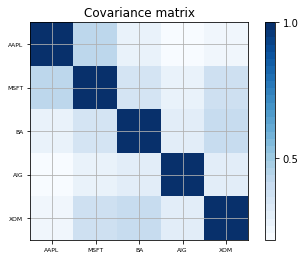

In [23]:
liste=list(df_r1.columns.values)
liste=liste[1:]
def correlation_matrix(df):
    from matplotlib import pyplot as plt
    from matplotlib import cm as cm

    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    cmap = cm.get_cmap('Blues', 30)
    cax = ax1.imshow(df.corr(), interpolation="nearest", cmap=cmap)
    ax1.grid(True)
    plt.title('Covariance matrix')
    labels=["",liste[0],liste[1],liste[2],liste[3],liste[4]]
    ax1.set_xticklabels(labels,fontsize=6)
    ax1.set_yticklabels(labels,fontsize=6)
    # Add colorbar, make sure to specify tick locations to match desired ticklabels
    fig.colorbar(cax, ticks=[-1,-.5,0,.5,1])
    plt.show()

correlation_matrix(df_r1)

Very nice. We now have an idea about how the stock correlate with each other. Lets now try to calculate which have provided the best risk adjusted return. Firstly, we need the standard deviations.

In [24]:
table=pd.DataFrame(index=['ann. return', 'std', 'sharpe ratio'], columns=liste)
table
for l in liste:
    table[l]['std']=df_r1[l].std()
table

,AAPL,MSFT,BA,AIG,XOM
ann. return,NaN,NaN,NaN,NaN,NaN
std,0.0269652,0.0197057,0.0194705,0.0359655,0.01532
sharpe ratio,NaN,NaN,NaN,NaN,NaN


Then we find the annualized returns

In [25]:
for l in liste:
    x=stocks_df.loc[df_p['ticker']==l,'adjusted_close'].values
    x=(x[0]/x[-1])**(1/20)-1
    table[l]['ann. return']=x
table

,AAPL,MSFT,BA,AIG,XOM
ann. return,0.346323,0.128563,0.133449,-0.119016,0.0785695
std,0.0269652,0.0197057,0.0194705,0.0359655,0.01532
sharpe ratio,NaN,NaN,NaN,NaN,NaN


The sharpe ratio is the annualized return divided by the std. This provides us with the following sharpe ratios.

In [26]:
for l in liste:
    table[l]['sharpe ratio']=table[l]['ann. return']/table[l]['std']
table

,AAPL,MSFT,BA,AIG,XOM
ann. return,0.346323,0.128563,0.133449,-0.119016,0.0785695
std,0.0269652,0.0197057,0.0194705,0.0359655,0.01532
sharpe ratio,12.8433,6.52415,6.85391,-3.30915,5.12857


Yay! We now know the best investment. Go long! :D